# D2W 2D Project Task 2

<div class="alert alert-block alert-info">

**Contents**

- [Group Members](#Group-Members)  
- [Introduction](#Introduction)
- [Key Files](#Key-Files)
- [Data Pre-Processing](#Data-Pre-Processing)
- [Prepare dataset for training model](#Prepare-dataset-for-training-model)
- [Train Model](#Train-Model)
- [Model Training Logs](#Model-Training-Logs)
- [Evaluate Model](#Evaluate-Model)


</div>

## Group Members 

[Return to top](#D2W-2D-Project-Task-2)  

| Name | ID | Contribution |
| :-: | :-: | :-: |
| Dickson Neo Jia Xuan | 1005203 | Sourcing of data |
| Wang Siyang | 1005485 | Pre-process data, Train model  and evaluate model |
| Fu Meihui | 1004864 | Data visualization, Video presentation |
| James Huang Yong Heng | 1005461 | Sourcing of data |
| Yeo Wan Li | 1005321 | Data visualization |


## Introduction

[Return to top](#D2W-2D-Project-Task-2)  

**Background**: Towards the end of a COVID-19 outbreak in a country, governments will want to estimate the Reproduction rate of COVID-19 to decide whether to open up restrictions. However, Reproduction rates are not easy to calculate, and if we are able to estimate it based on variables that are easily found online, this can save the government valuable time and money.

**Problem Statement**: Estimate the Reproduction rate of COVID-19 in a country, based on the movment trends of said country

**Method**: Train Multiple Linear Regression Model with 12 features through gradient descent algorithm

## Key Files

[Return to top](#D2W-2D-Project-Task-2)

Below is the directory tree that shows the location of datasets and model (jupyter notebook)

```
task_2
├── Task-2-Final.ipynb
├── owid-covid-data.csv
└── Region_Mobility_Report_CSVs
    ├── 2020_AE_Region_Mobility_Report.csv
    ├── ...
    └── 2021_ZW_Region_Mobility_Report.csv
    
```

These files have the following specifications:
- `Task-2-Final.ipynb` - contains the code needed to extract data, build model and predict results
- `owid-covid-data.csv` - database of each country's COVID-related data in each day. Data is downloaded from
[Our World in Data (OWID)](https://github.com/owid/covid-19-data/tree/master/public/data)
- `Region_Mobility_Report_CSVs` - database of each country's movement trends, as collected by [Google](https://www.google.com/covid19/mobility/). Since the reproduction rate also depends on social factors, such as the amount of people in public spaces, we expect that there is a relationship between movement trends and reproduction rate

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data Pre-Processing

[Return to top](#D2W-2D-Project-Task-2)  

Each country's movement trend data for 2020 and 2021 are in different .csv files. To allow the user to quickly create the dataset that contains the movement trends and reproduction rate of different countries, we used a dictionary that maps each country name as it appears in the `location` column of `owid-covid-data.csv` to the abbreviation that was used in naming of the movement trend data files.  

The code for processing the data, such as removing NaN values and removing data at the county level (Reproduction Rate of covid was not available at the county level of all countries) is also done in this section.  

Data Visualization was also carried out to ensure that there was a clear relationship between the movement trend data and the Reproduction Rate. Since we observe that the reproduction rate grows exponentially for all 6 features, we applied the exponential of each feature to create a total of 12 features.

In [2]:
country = 'United Kingdom'
country_map = {'United States':'US','United Kingdom':'GB','Singapore':'SG','Vietnam':'VN'}

In [3]:
##import dataset that contains reproduction rate data
df = pd.read_csv("owid-covid-data.csv")

In [4]:
#set the country
country_df = df[df['location']==country]

#take only necessary features from this dataframe
country_df_features = ['location','date','reproduction_rate']
country_df = country_df.loc[:,country_df_features]

#edit the date feature (for merge purposes later)
country_df.loc[:,'date'] = pd.to_datetime(country_df.loc[:,'date'])

#remove NA
country_df = country_df[country_df['reproduction_rate'].notna()]
country_df

,location,date,reproduction_rate
118585,United Kingdom,2020-03-03,2.11
118586,United Kingdom,2020-03-04,2.06
118587,United Kingdom,2020-03-05,2.09
118588,United Kingdom,2020-03-06,2.24
118589,United Kingdom,2020-03-07,2.36
...,...,...,...
119175,United Kingdom,2021-10-14,1.13
119176,United Kingdom,2021-10-15,1.15
119177,United Kingdom,2021-10-16,1.16
119178,United Kingdom,2021-10-17,1.18


In [5]:
def get_feature_df(year):
    #import the features from google database
    feature_df = pd.read_csv('Region_Mobility_Report_CSVs/'+str(year)+'_'+country_map[country]+'_Region_Mobility_Report.csv')

    feature_df_features = ['date', 'retail_and_recreation_percent_change_from_baseline',\
                           'grocery_and_pharmacy_percent_change_from_baseline',\
                           'parks_percent_change_from_baseline',\
                           'transit_stations_percent_change_from_baseline',\
                           'workplaces_percent_change_from_baseline',\
                           'residential_percent_change_from_baseline']

    #choose the national data only 
    #(sub_region_1 is county data, national data is NA for this column)
    feature_df = feature_df[feature_df['sub_region_1'].isna()]

    #choose all necessary features
    feature_df = feature_df.loc[:,feature_df_features]

    #edit the date feature (for merge purposes later)
    feature_df.loc[:,'date'] = pd.to_datetime(feature_df.loc[:,'date'])

    #rename each feature to shorten the long name
    mapping = {}
    for i in range(1,len(feature_df.columns)):
        ending = '_percent_change_from_baseline'
        feature = feature_df.columns[i]
        short_name = feature_df.loc[:,feature].name[:-len(ending)]
        mapping[feature] = short_name   
    feature_df.rename(columns=mapping,inplace=True)

    #create the exponential feature
    for i in range(1,len(feature_df.columns)):
        feature = feature_df.columns[i]
        feature_df[feature+'_exp'] = np.exp((feature_df[feature]+100)/10)
    
    return feature_df

feature_df = get_feature_df(2021)

In [6]:
#join reproduction rate data and movement trend data together
joined_df = pd.merge(country_df,feature_df,on="date",how="inner")

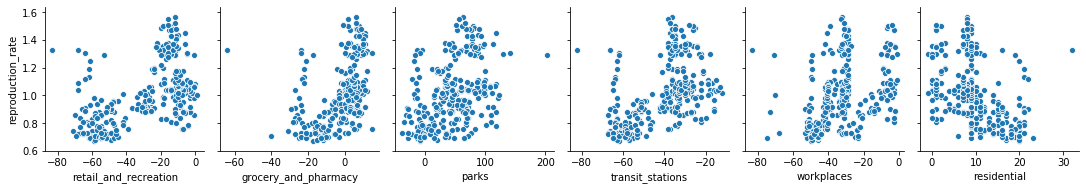

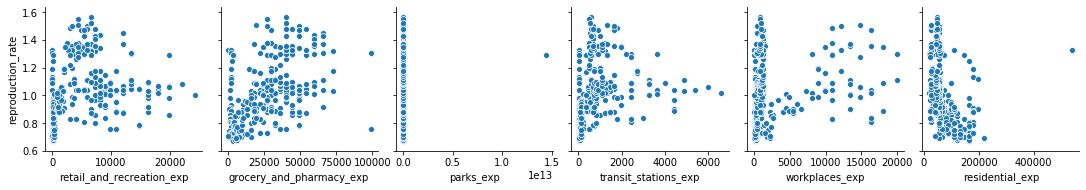

In [7]:
#scatter plot of each feature against the reproduction rate
feature_names = joined_df.columns[3:]
for i in range(0,len(feature_names),6):
    myplot=sns.pairplot(data = joined_df,
                        y_vars=['reproduction_rate'],
                        x_vars=feature_names[i:i+6])

In [8]:
df = joined_df
df

,location,date,reproduction_rate,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,retail_and_recreation_exp,grocery_and_pharmacy_exp,parks_exp,transit_stations_exp,workplaces_exp,residential_exp
0,United Kingdom,2021-01-01,1.33,-83.0,-64.0,-5.0,-82.0,-83.0,32.0,5.473947,36.598234,13359.726830,6.049647,5.473947,540364.937247
1,United Kingdom,2021-01-02,1.33,-68.0,-24.0,-12.0,-66.0,-39.0,16.0,24.532530,1998.195895,6634.244006,29.964100,445.857770,109097.799277
2,United Kingdom,2021-01-03,1.31,-64.0,-24.0,-8.0,-62.0,-29.0,11.0,36.598234,1998.195895,9897.129059,44.701184,1211.967074,66171.160168
3,United Kingdom,2021-01-04,1.29,-53.0,-17.0,-16.0,-62.0,-49.0,19.0,109.947172,4023.872394,4447.066748,44.701184,164.021907,147266.625241
4,United Kingdom,2021-01-05,1.25,-61.0,-21.0,-18.0,-63.0,-50.0,20.0,49.402449,2697.282328,3640.950307,40.447304,148.413159,162754.791419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,United Kingdom,2021-10-14,1.13,-11.0,5.0,37.0,-30.0,-29.0,7.0,7331.973539,36315.502674,890911.165979,1096.633158,1211.967074,44355.855130
287,United Kingdom,2021-10-15,1.15,-9.0,6.0,38.0,-26.0,-29.0,6.0,8955.292703,40134.837431,984609.111229,1635.984430,1211.967074,40134.837431
288,United Kingdom,2021-10-16,1.16,-12.0,0.0,26.0,-21.0,-8.0,2.0,6634.244006,22026.465795,296558.565298,2697.282328,9897.129059,26903.186074
289,United Kingdom,2021-10-17,1.18,-10.0,-2.0,29.0,-21.0,-6.0,2.0,8103.083928,18033.744928,400312.191330,2697.282328,12088.380730,26903.186074


## Prepare dataset for training model

[Return to top](#D2W-2D-Project-Task-2)

Model will be trained using the train dataset, which is a subset of the entire dataset. Test_size is set at 0.3, since more training data will help to produce a model with higher accuracy, but we still want to retain a significant proportion from the model to test its ability to generalize to unseen data.  

To create the train dataset, data is also split into train and test set randomly. The random state is set as fixed, in order to do a meaningful comparison between different models that were generated throughout the modelling process.  

In [9]:
feature_names = ['retail_and_recreation','grocery_and_pharmacy','parks','transit_stations','workplaces','residential',\
                'retail_and_recreation_exp','grocery_and_pharmacy_exp','parks_exp','transit_stations_exp','workplaces_exp',\
                'residential_exp']
target_name = ['reproduction_rate']

In [10]:
##split data into train and test set
def get_features_targets(df,feature_names,target_name):
    ###
    ### YOUR CODE HERE
    df_feature = df.loc[:,feature_names]
    df_target = pd.DataFrame(df.loc[:,target_name])
    return df_feature, df_target

def split_data(df_feature, df_target, random_state=None, test_size=0.5):
    np.random.seed(random_state)
    n = df_feature.shape[0]
    size = int(n*test_size)
    
    test_idx = np.random.choice(n, size,replace = False)
    df_feature_test = pd.DataFrame(df_feature.iloc[test_idx])
    df_target_test = pd.DataFrame(df_target.iloc[test_idx])

    train_idx = list(set(i for i in range(n)) - set(test_idx))
    df_feature_train = pd.DataFrame(df_feature.iloc[train_idx])
    df_target_train = pd.DataFrame(df_target.iloc[train_idx])
    return df_feature_train, df_feature_test, df_target_train, df_target_test

df_features, df_target = get_features_targets(df,feature_names,target_name)
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features,df_target,100,0.3)

## Train Model

[Return to top](#D2W-2D-Project-Task-2)  

Since all factors are continuous data and increase at an increasing rate, Multiple Linear Regression model is suitable to model the reproduction rate of COVID-19, based on the movement trends. Using gradient descent, we iteratively improve the model.

In [11]:
##helper functions for preparing data for insertion into model
def normalize_z(df):
    mean = df.mean(axis=0)
    std = df.std(axis=0)
    #carry out the normalization procedure
    dfout = (df - mean)/std
    #display(dfout)
    return dfout

def prepare_features(df_feature):
    df_feature = normalize_z(df_feature)
    m = df_feature.shape[0]
    first_column = np.ones(m).reshape(m,1)
    x_matrix = np.concatenate((first_column,df_feature),1)
    return x_matrix

def prepare_target(df_target):
    return df_target.to_numpy()

In [12]:
##set up cost function
def compute_cost(X, y, beta):
    J = 0
    hypothesis  = np.matmul(X,beta)
    error = hypothesis - y
    m = y.shape[0]
    J = (1/(2*m)) * np.matmul(error.T,error)
    return J

##set up gradient descent
def gradient_descent(df, beta, alpha, num_iters):
    df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features,df_target,100,0.3)
    
    X_train = prepare_features(df_features_train)
    y_train = prepare_target(df_target_train)
    X_test = prepare_features(df_features_test)
    y_test = prepare_target(df_target_test)
    
    m = y_train.shape[0]
    J_storage_train = np.zeros((num_iters,1))
    J_storage_test = np.zeros((num_iters,1))
    for i in range(num_iters):
        derivative = (1/m) * np.matmul(X_train.T, (np.matmul(X_train,beta)-y_train))
        beta = beta - alpha * derivative
        J_storage_train[i] = compute_cost(X_train,y_train,beta)
        J_storage_test[i] = compute_cost(X_test,y_test,beta)
    return beta, J_storage_train, J_storage_test

##optimize weights
n = len(df_features.columns)
iterations = 5000
alpha = 0.1
beta = np.zeros((n+1,1))

beta, J_storage_train, J_storage_test = gradient_descent(df, beta, alpha, iterations)

In [13]:
J_storage_train[-1][0]

0.010849701465644712

## Model Training Logs

[Return to top](#D2W-2D-Project-Task-2)

During training of data, it is shown that the cost of train datasets do not change much after 1000 iterations. Hence, we can conclude that the model has reached a local minimum cost value. Overfitting did not occur as the difference in cost between test and train dataset continued to stay the same.

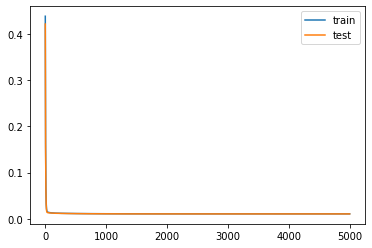

In [14]:
plt.plot(J_storage_train)
plt.plot(J_storage_test)
plt.legend(['train','test'])

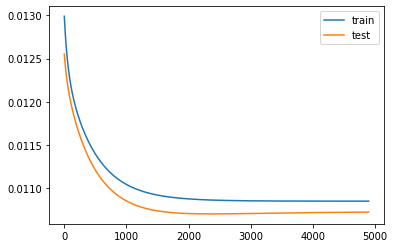

In [15]:
#zoom-in picture of the tail, 
#since the initial high cost makes it difficult to compare
#cost of train and test over iterations towards the end

plt.plot(J_storage_train[100:])
plt.plot(J_storage_test[100:])
plt.legend(['train','test'])

## Evaluate Model

[Return to top](#D2W-2D-Project-Task-2)

**Chosen Metric**: RMSE was chosen as a metric in order to evaluate the accuracy of this model. The closer it is to 0, the more accurate it is.  

**Results**: The root mean squared error of the model is 0.14 (3s.f). This shows that there on average, there is an error of 0.14 from the actual reproduction rate of COVID-19 for each data point.

**Limitations**: 

1. *Using movement trends to predict reproduction rate of COVID-19 is not useful in countries that managed to successfully pursue a 'zero-COVID' strategy*  

When a country is able to successfully keep COVID-19 transmission to virtually zero and ensure that there are strict border measures in place, people are then able to visit public places without increasing the reproduction rate of COVID-19, as there is little to no carriers of the virus in the community. Hence, movement trends will not be a good predictor in these countries, which include countries in the East Asia region and Australia. This can be seen when modelling for Singapore and Vietnam, as compared to United Kingdom and United States as shown in the table below.  

| Country | RMSE (3 s.f.) |
| :-: | :-: |
| United Kingdom | 0.146 |
| United States | 0.181 |
| Singapore | 0.374 |
| Vietnam | 0.317 |

However, this will be less likely of a limitation, as more countries are accepting the necessity to live with COVID-19, which will make the virus endemic and constantly present in the community, albeit at a low rate. Hence, this model will still be useful for such countries who are changing from a "zero-COVID" strategy to an "endemic-COVID" strategy.

2. *Other factors that affect COVID-19 reproduction value are not considered*

Reproduction rate of COVID-19 are not solely driven by societal factors. As more variants of COVID-19 appear, the transmissability of the virus may increase, which may further drive up the reproduction value of COVID-19. Further studies can make use of biological data to further improve this model.

In [16]:
##evaluate cost on test data
def predict(df_feature, beta):
    #df_feature = prepare_features(df_feature)
    df_feature = prepare_features(df_feature)
    pred_y = np.matmul(df_feature,beta)
    return pred_y

pred = predict(df_features_test,beta)

In [17]:
## change predicted results into Dataframe form, so that can compare with original data
mod_pred = pd.DataFrame(pred, columns = ['reproduction_rate_predicted'], index = df_target_test.index)

In [18]:
pd.concat([df_target_test,mod_pred],1)

,reproduction_rate,reproduction_rate_predicted
243,1.05,1.151972
85,0.86,0.893401
205,0.81,1.211208
234,1.08,1.006881
239,1.03,0.954074
...,...,...
281,1.09,1.102363
123,0.92,0.972950
3,1.29,0.908986
148,1.30,1.104394


Text(0, 0.5, 'reproduction_rate')

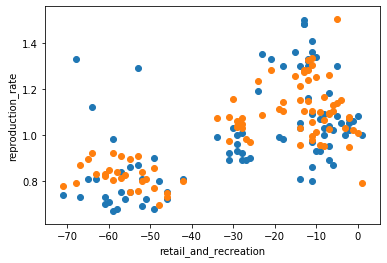

In [19]:
plt.scatter(df_features_test[feature_names[0]],df_target_test)
plt.scatter(df_features_test[feature_names[0]],pred)
plt.xlabel(feature_names[0])
plt.ylabel(target_name[0])

Text(0, 0.5, 'reproduction_rate')

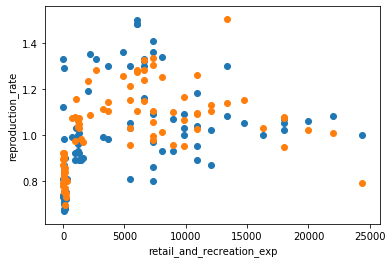

In [20]:
plt.scatter(df_features_test[feature_names[6]],df_target_test)
plt.scatter(df_features_test[feature_names[6]],pred)
plt.xlabel(feature_names[6])
plt.ylabel(target_name[0])

In [21]:
def r2_score(y, ypred):
    error_n = y - ypred
    numerator = np.matmul(error_n.T,error_n)[0][0]/y.shape[0]
    #print(numerator)
    error_d = y - np.full((y.shape[0],y.shape[1]),np.mean(y))
    denominator = np.matmul(error_d.T,error_d)[0][0]/y.shape[0]
    #print(denominator)
    
    return 1 - numerator/denominator


def root_mean_squared_error(target, pred):
    error = target - pred
    n = target.shape[0]
    mse = ((1/n) * np.matmul(error.T,error))[0][0]
    return mse ** 0.5
    ###
    pass

In [22]:
# change target test set to a numpy array
target = prepare_target(df_target_test)

# Calculate r2 score by calling a function
r2 = r2_score(target,pred)
rmse = root_mean_squared_error(target,pred)
print(r2)
print(rmse)

0.5442320130466454
0.14644687363824094
